In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs

import xarray as xr

import sys
import os.path as op


from dask.distributed import Client

%load_ext autoreload
%autoreload 2

In [2]:
SERVER = 'IAC'
# SERVER = 'LOCAL'
if SERVER == 'IAC':
    CODE_ROOT = '/home/qnicolas/'
elif SERVER == 'LOCAL':
    CODE_ROOT = '/Users/qnicolas/'
else:
    raise ValueError('SERVER not recognized. Set SERVER to IAC or LOCAL.')

DATA_ROOT = op.join(CODE_ROOT, 'stationaryWave/data/')
for p in [op.join(CODE_ROOT, 'iac_notebooks/tools/'),
          op.join(CODE_ROOT, 'stationaryWave/src/'),]:
    if p not in sys.path:
        sys.path.append(p)

from generalTools import ddx, ddy, sel_months, quickplot, lon_360_to_180, wrap_lon, invert_latitudes, sel_box, add_gridlines


In [95]:
client.close()

In [96]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit='20GB',dashboard_address=':30000')

# Evaluate T300 anomalies over JJA

In [52]:
era5_monthly_2deg = xr.open_dataset("/net/helium/atmosdyn/qnicolas/era5monthly/e5.monthly.all.2deg.1980-2020.nc")

In [53]:
T300 = era5_monthly_2deg.T.sel(level=300)

T300_deseas = T300.groupby('time.month').apply(lambda x: x - x.mean('time'))

T300_deseas_jjamean = sel_months(T300_deseas,[6,7,8]).coarsen(time=3).mean()

T300_deseas_jjamean_prime = T300_deseas_jjamean - T300_deseas_jjamean.mean('longitude')

In [104]:
en_years = np.array([1982,1987,1991,1997,2002,2004,2009,2015])

Text(0.5, 0.98, 'ERA5 300hPa Temperature Anomalies during developing El Niño JJA, without subtracting zonal mean')

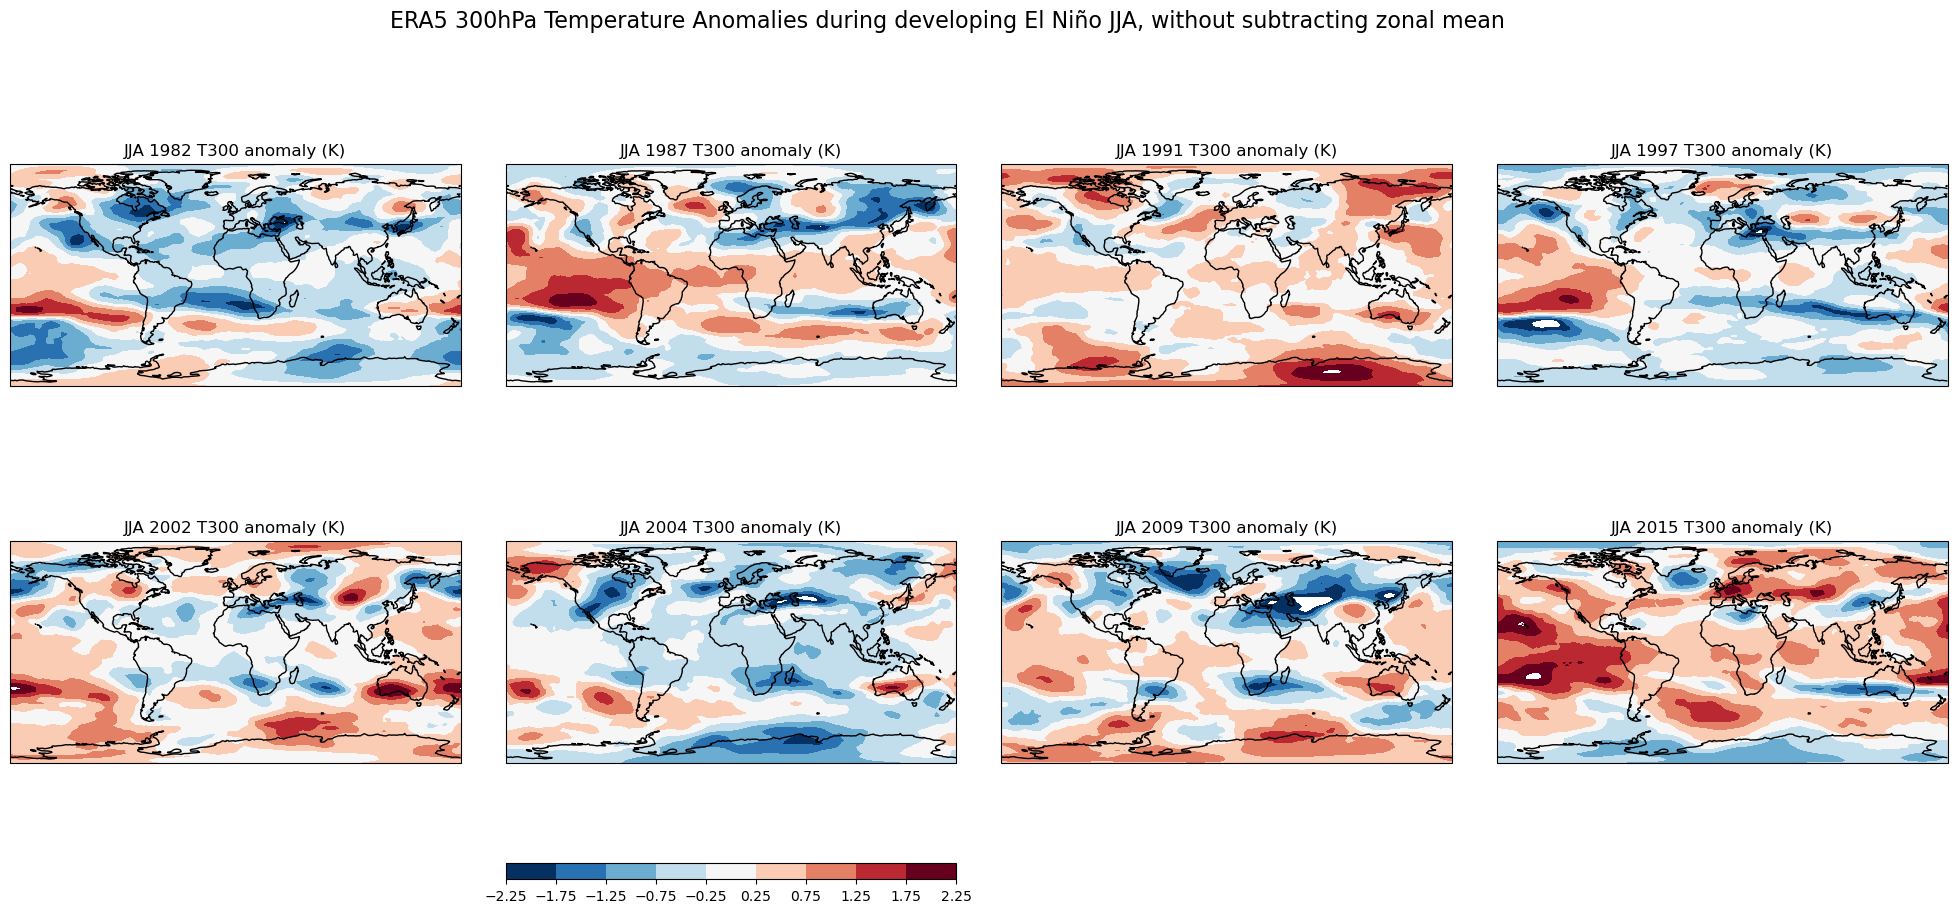

In [32]:
fig = plt.figure(figsize=(25,10))
gs = GridSpec(3,4,figure=fig,wspace=0.1,height_ratios=[1,1,0.05])
axs = np.array([[fig.add_subplot(gs[i,j],projection=ccrs.PlateCarree()) for j in range(4)] for i in range(2)])
for year,ax in zip(en_years,axs.flatten()):
    cf = wrap_lon(T300_deseas_jjamean).sel(time=str(year)).isel(time=0).plot.contourf(ax=ax,levels=np.arange(-2.25,2.26,.5),cmap='RdBu_r',extend='neither',transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.coastlines()
    ax.set_title(f'JJA {year} T300 anomaly (K)')
axcbar = fig.add_subplot(gs[2,1])
cbar = fig.colorbar(cf, cax=axcbar, orientation='horizontal')
fig.suptitle('ERA5 300hPa Temperature Anomalies during developing El Niño JJA, without subtracting zonal mean', fontsize=16)

Text(0.5, 0.98, 'ERA5 300hPa Temperature Anomalies during developing El Niño JJA, with zonal mean subtracted')

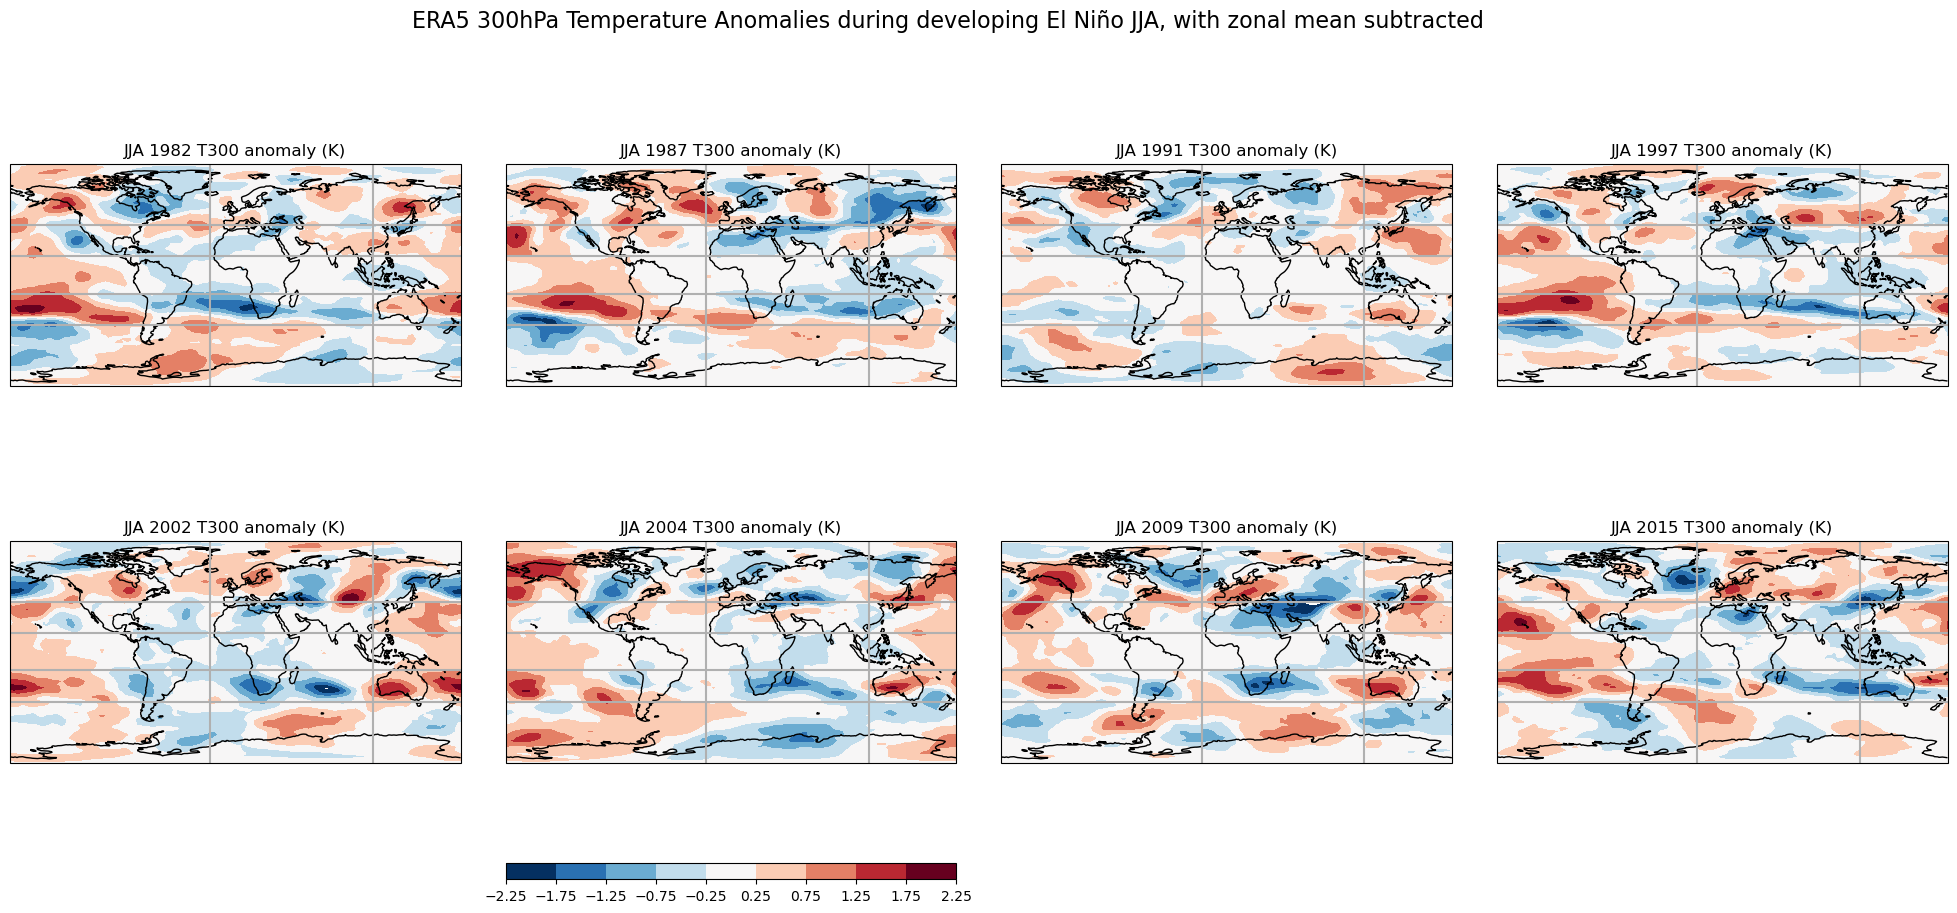

In [48]:
fig = plt.figure(figsize=(25,10))
gs = GridSpec(3,4,figure=fig,wspace=0.1,height_ratios=[1,1,0.05])
axs = np.array([[fig.add_subplot(gs[i,j],projection=ccrs.PlateCarree()) for j in range(4)] for i in range(2)])
for year,ax in zip(en_years,axs.flatten()):
    cf = wrap_lon(T300_deseas_jjamean_prime).sel(time=str(year)).isel(time=0).plot.contourf(ax=ax,levels=np.arange(-2.25,2.26,.5),cmap='RdBu_r',extend='neither',transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.coastlines()
    ax.set_title(f'JJA {year} T300 anomaly (K)')
    add_gridlines(ax,lat=[-40,-15,15,40],lon=[-20,110])
axcbar = fig.add_subplot(gs[2,1])
cbar = fig.colorbar(cf, cax=axcbar, orientation='horizontal')
fig.suptitle('ERA5 300hPa Temperature Anomalies during developing El Niño JJA, with zonal mean subtracted', fontsize=16)


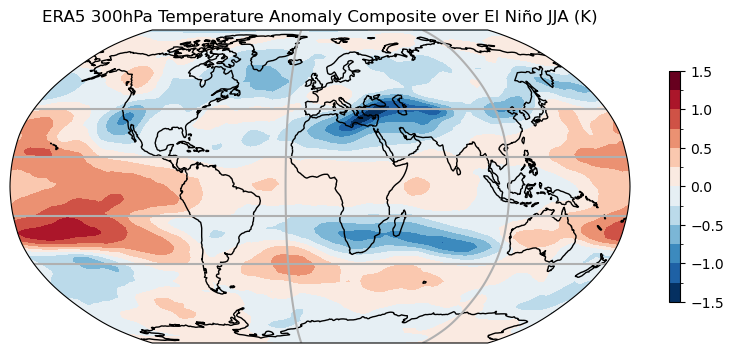

In [ ]:
# Plot composite over EN years
T300_deseas_jjamean_encomp = T300_deseas_jjamean.isel(time=np.array(en_years)-1980).mean('time')
ax = quickplot(wrap_lon(T300_deseas_jjamean_encomp),levels=np.arange(-1.5,1.51,.25),cmap='RdBu_r',extend='neither',fast=False)
ax.set_title('ERA5 300hPa Temperature Anomaly Composite over El Niño JJA (K)')
add_gridlines(ax,lat=[-40,-15,15,40],lon=[-20,110])


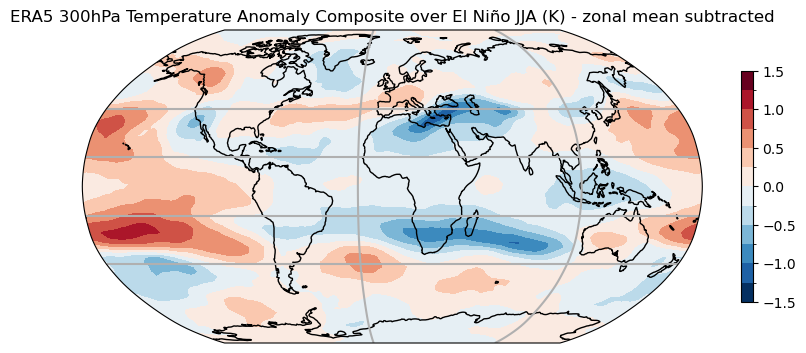

In [62]:
# Plot composite over EN years
T300_deseas_jjamean_encomp = T300_deseas_jjamean_prime.isel(time=np.array(en_years)-1980).mean('time')
ax = quickplot(wrap_lon(T300_deseas_jjamean_encomp),levels=np.arange(-1.5,1.51,.25),cmap='RdBu_r',extend='neither',fast=False)
ax.set_title('ERA5 300hPa Temperature Anomaly Composite over El Niño JJA (K) - zonal mean subtracted')
add_gridlines(ax,lat=[-40,-15,15,40],lon=[-20,110])


In [54]:
subtropics_N_box = [-20,110,15,40]
subtropics_S_box = [-20,110,-40,-15]

In [55]:
def get_cold_index(T):
    return (sel_box(T,subtropics_S_box).mean(['latitude','longitude']) + sel_box(T,subtropics_N_box).mean(['latitude','longitude'])) / 2

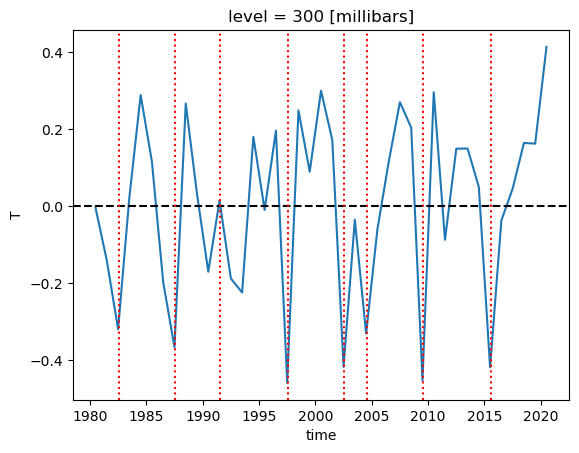

In [56]:
get_cold_index(lon_360_to_180(T300_deseas_jjamean_prime)).plot()
plt.axhline(0.0, color='k', linestyle='--')
for year in en_years:
    plt.axvline(np.datetime64(f'{year}-07-15'), color='r', linestyle=':')

# Average ERA5 over JJA 1980-2020

In [109]:
era5_SP = xr.open_dataset("/net/helium/atmosdyn/qnicolas/era5monthly/e5.mean.psfc.nc")
# era5_SP_2deg = era5_SP.interp_like(era5_monthly_2deg)

<GeoAxes: xlabel='longitude', ylabel='latitude [degrees_north]'>

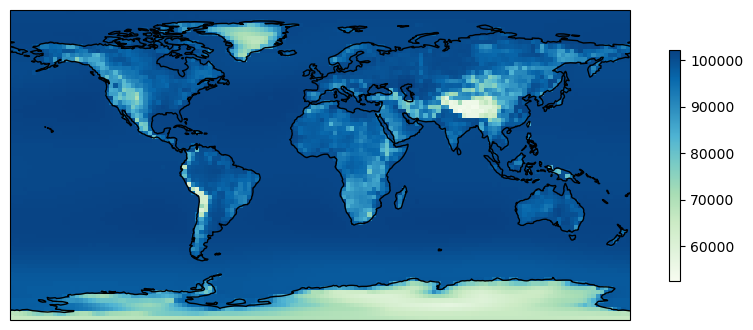

In [62]:
quickplot(era5_SP_2deg.PSFC)

In [66]:
era5_basicstate_jja_2deg = sel_months(era5_monthly_2deg[['T','U','V','W','Z']],[6,7,8]).mean('time')

In [67]:
era5_basicstate_jja_2deg['SP'] = era5_SP_2deg.PSFC

Text(0.5, 0.98, 'JJA basic state from ERA5 1980-2020')

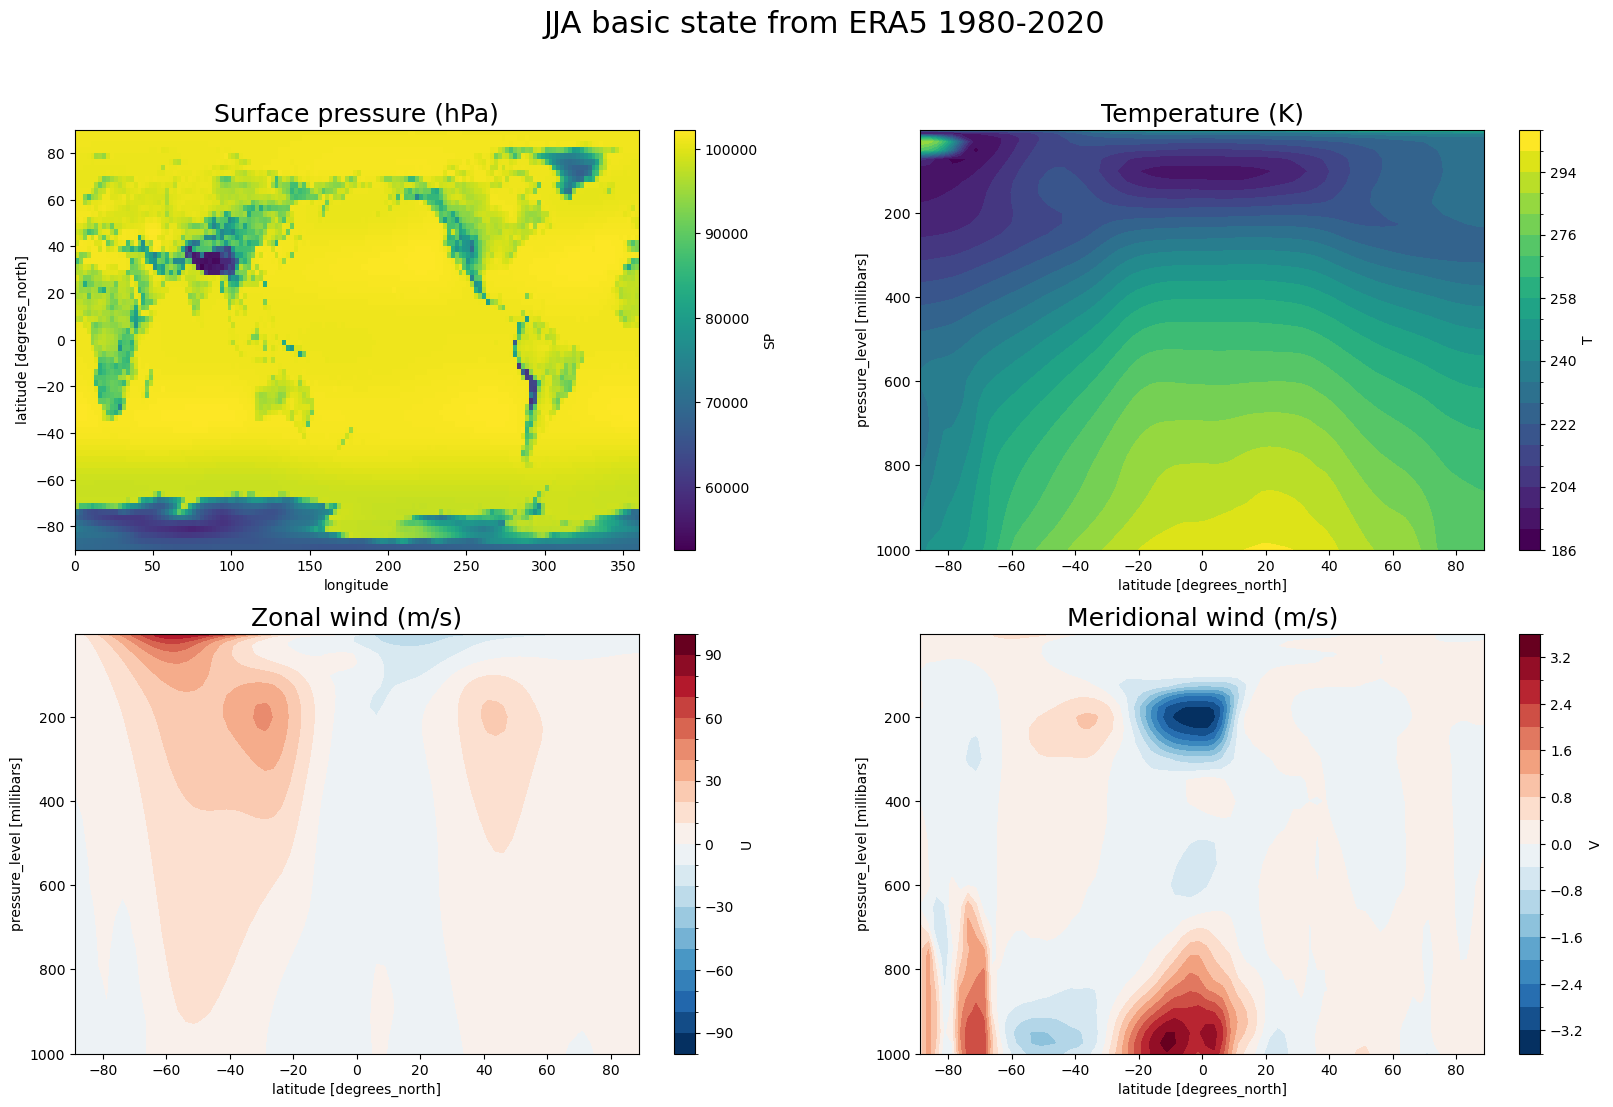

In [71]:
# basic state
fig,axs = plt.subplots(2,2,figsize=(20,12)); axs=axs.reshape(-1)
for i,(ax,var) in enumerate(zip(axs,(era5_basicstate_jja_2deg.SP,era5_basicstate_jja_2deg.T,era5_basicstate_jja_2deg.U,era5_basicstate_jja_2deg.V))):
    if i==0:
        var.plot(ax=ax)
    else:
        var.mean('longitude').plot.contourf(ax=ax,y='level',yincrease=False,levels=21)
for ax,name in zip(axs,('Surface pressure (hPa)','Temperature (K)','Zonal wind (m/s)','Meridional wind (m/s)')):
    ax.set_title(name,fontsize=18)
fig.suptitle('JJA basic state from ERA5 1980-2020',fontsize=22)

In [73]:
era5_basicstate_jja_2deg.rename(level='pressure', latitude='lat', longitude='lon').to_netcdf(op.join(DATA_ROOT,'input/era5_jja_basic_state.nc'))

# Calculate mean QDIAB

In [81]:
era5_basicstate_jja_2deg = xr.open_dataset(op.join(DATA_ROOT,'input/era5_jja_basic_state.nc'))

In [28]:
era5_p25deg = xr.open_zarr("/net/helium/atmosdyn/qnicolas/era5monthly/e5.monthly.TQUVWZ.1979-2024.zarr").sel(time=slice('1980-01-01','2020-12-31')).drop_vars(['expver','number'])
# era5_p25deg = invert_latitudes(era5_p25deg)
era5_p25deg = invert_latitudes(era5_p25deg,latitude='level')
era5_p25deg = era5_p25deg.rename(level='pressure', latitude='lat', longitude='lon')

In [29]:
era5_jja_p25deg = sel_months(era5_p25deg[['T','U','V','W']],[6,7,8]).coarsen(time=3).mean()

In [30]:
era5_jja_p25deg['SP'] = era5_SP.PSFC

In [31]:
def calc_HTadv(ds):
    """Calculate horizontal heat advection"""
    return ds.U * ddx(ds.T) + ds.V * ddy(ds.T) 
def calc_VTadv(ds):
    """Calculate vertical heat advection"""
    # return ds.W * (ds.T + ds.Z * 9.81/1004.).differentiate('pressure')/100.
    return ds.W * (ds.T.differentiate('pressure')/100. - 287. * ds.T / (1004. * ds.pressure * 100.))

## Test with different resolutions

In [168]:
Qdiab_minus_ehfd = (calc_HTadv(era5_basicstate_jja_2deg) + calc_VTadv(era5_basicstate_jja_2deg))

In [180]:
era5_basicstate_test = era5_jja_p25deg.isel(time=20).compute()
Qdiab_minus_ehfd_hires = (calc_HTadv(era5_basicstate_test) + calc_VTadv(era5_basicstate_test))

In [181]:
Qdiab_minus_ehfd_downsampled_1deg = Qdiab_minus_ehfd_hires.coarsen(lat=4,lon=4, boundary='trim').mean()
Qdiab_minus_ehfd_downsampled_2deg = Qdiab_minus_ehfd_downsampled_1deg.interp_like(era5_basicstate_jja_2deg)

Text(0.5, 1.0, 'Qdiab - EHFD diagnosed from ERA5 as a residual of the thermo eqn')

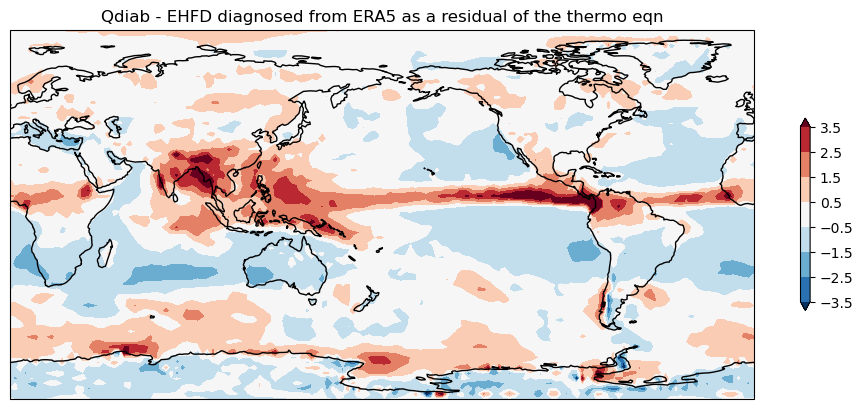

In [182]:
_,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},figsize=(12,5))
(Qdiab_minus_ehfd_downsampled_2deg.sel(pressure=slice(100,1000)).where(Qdiab_minus_ehfd.pressure < era5_basicstate_jja_2deg.SP/100).fillna(0.).integrate('pressure') * 86400 / 900).plot.contourf(ax=ax,levels=np.arange(-3.5,3.51,1.), cmap = 'RdBu_r',extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':.5})
ax.coastlines()
ax.set_title("Qdiab - EHFD diagnosed from ERA5 as a residual of the thermo eqn")

Text(0.5, 1.0, 'Qdiab - EHFD diagnosed from ERA5 as a residual of the thermo eqn')

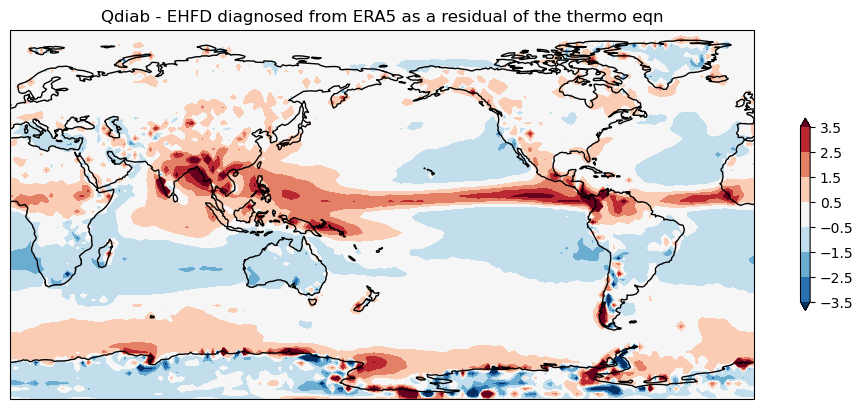

In [183]:
_,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},figsize=(12,5))
(Qdiab_minus_ehfd.sel(pressure=slice(100,1000)).where(Qdiab_minus_ehfd.pressure < era5_basicstate_jja_2deg.SP/100).fillna(0.).integrate('pressure') * 86400 / 900).plot.contourf(ax=ax,levels=np.arange(-3.5,3.51,1.), cmap = 'RdBu_r',extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':.5})
ax.coastlines()
ax.set_title("Qdiab - EHFD diagnosed from ERA5 as a residual of the thermo eqn")

## Calculate for all JJAs

In [32]:
Qdiab_minus_ehfd_hires = calc_HTadv(era5_jja_p25deg) + calc_VTadv(era5_jja_p25deg)

In [36]:
Qdiab_minus_ehfd_hires = Qdiab_minus_ehfd_hires.drop_encoding()

In [37]:
Qdiab_minus_ehfd_hires.chunk(time=-1).to_zarr("/net/helium/atmosdyn/qnicolas/era5monthly/e5.monthly.Qdiab_minus_EHFD_jja_p25deg.1980-2020.zarr")

/home/qnicolas/.conda/envs/dedalus3/lib/python3.12/site-packages/zarr/api/asynchronous.py:197: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home/qnicolas/.conda/envs/dedalus3/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 19.08 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
Qdiab_minus_ehfd_hires = xr.open_zarr("/net/helium/atmosdyn/qnicolas/era5monthly/e5.monthly.Qdiab_minus_EHFD_jja_p25deg.1980-2020.zarr").__xarray_dataarray_variable__

In [48]:
test = Qdiab_minus_ehfd_hires[:,:].coarsen(lat=4,lon=4,boundary='trim').mean().sel(pressure=500).compute()

In [65]:
test_tmean = test.mean('time')
test_enmean = test.isel(time=np.array(en_years)-1980).mean('time')

In [ ]:
_,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},figsize=(12,5))
(test * 86400).plot.contourf(ax=ax,levels=np.arange(-3.5,3.51,1.)*2, cmap = 'RdBu_r',extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':.5})
ax.coastlines()
ax.set_title("Qdiab - EHFD diagnosed from ERA5 as a residual of the thermo eqn")

<GeoAxes: title={'center': 'pressure = 500.0 [hPa]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

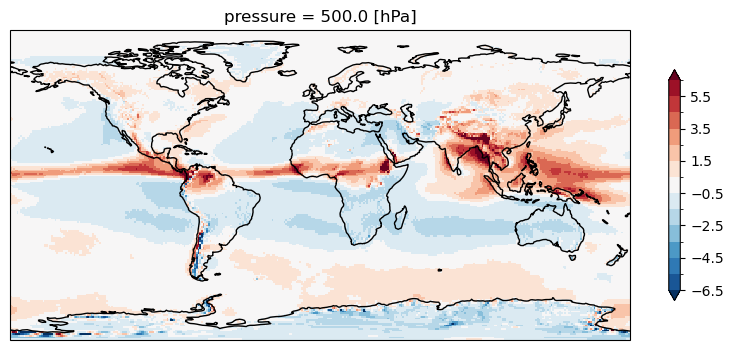

In [69]:
quickplot(test_tmean * 86400,cmap='RdBu_r',levels=np.arange(-3.25,3.26,.5)*2)

<GeoAxes: title={'center': 'pressure = 500.0 [hPa]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

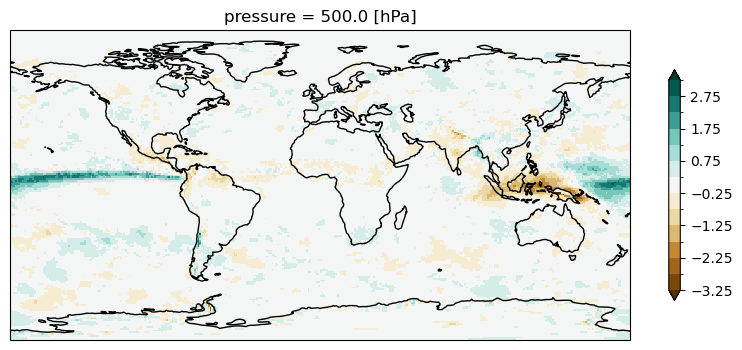

In [72]:
quickplot((test_enmean-test_tmean) * 86400,cmap='BrBG',levels=np.arange(-3.25,3.26,.5),extend='both')

<GeoAxes: title={'center': 'pressure = 500.0 [hPa]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

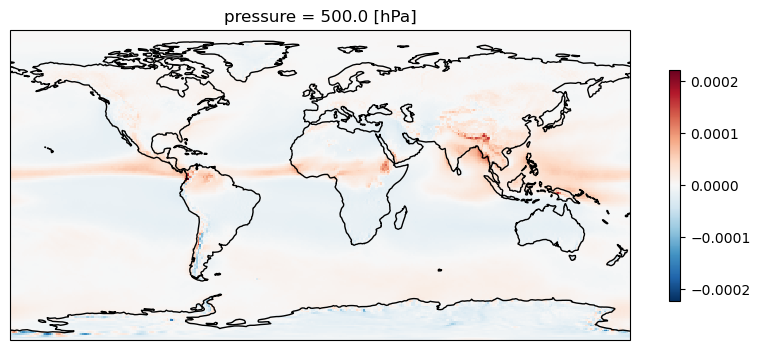

In [ ]:
quickplot(test_tmean,cmap='RdBu_r')

# Calculate mean EMFD

Done on Perlmutter (pressure level data not at IAC)

# Prepare forcing files

In [ ]:
era5_basicstate_jja_2deg = xr.open_dataset(op.join(DATA_ROOT,'input/era5_jja_basic_state.nc'))
era5_basicstate_jja_2deg

In [97]:
Qdiab_minus_ehfd_hires = xr.open_zarr("/net/helium/atmosdyn/qnicolas/era5monthly/e5.monthly.Qdiab_minus_EHFD_jja_p25deg.1980-2020.zarr").__xarray_dataarray_variable__

In [105]:
Qdiab_minus_ehfd_hires_coarse = Qdiab_minus_ehfd_hires[:,:].coarsen(lat=4,lon=4,boundary='trim').mean()
Qdiab_minus_ehfd_hires_coarse_allmean = Qdiab_minus_ehfd_hires_coarse.mean('time').compute()
Qdiab_minus_ehfd_hires_coarse_enmean = Qdiab_minus_ehfd_hires_coarse.isel(time=en_years-1980).mean('time').compute()
Qdiab_minus_ehfd_hires_coarse_enanom = Qdiab_minus_ehfd_hires_coarse_enmean - Qdiab_minus_ehfd_hires_coarse_allmean

In [113]:
skeleton = Qdiab_minus_ehfd_hires_coarse_enanom * 0
era5_SP_coarse = era5_SP.PSFC.rename(latitude='lat',longitude='lon').coarsen(lat=4,lon=4,boundary='trim').mean()

In [118]:
forcings = xr.merge([skeleton.isel(pressure=0).to_dataset(name='ZSFC'), 
                     Qdiab_minus_ehfd_hires_coarse_enanom.to_dataset(name = 'QDIAB'), 
                     skeleton.to_dataset(name = 'EHFD'), 
                     skeleton.to_dataset(name='EMFD_U'), 
                     skeleton.to_dataset(name='EMFD_V'), 
                     era5_SP_coarse.to_dataset(name='SP')])

<GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

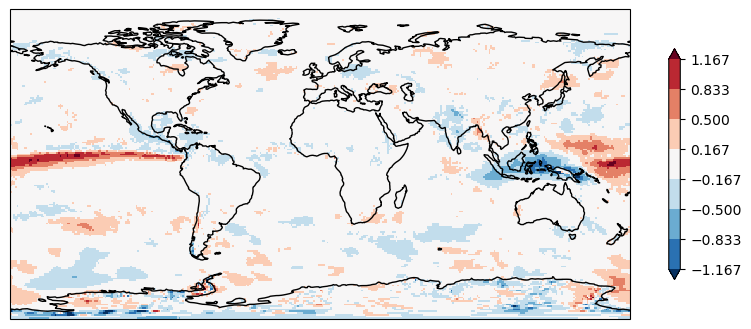

In [119]:
quickplot(forcings.QDIAB.integrate('pressure')/1e3 * 86400,cmap='RdBu_r',levels = np.arange(-3.5,3.6,1)/3)

In [124]:
forcings.to_netcdf(DATA_ROOT + "input/era5_jja_EN_forcings.nc")